# Tight binding Project
Tyjal DeWolf-Moura

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh
from numpy import linalg as LA
from mpl_toolkits import mplot3d

# hamiltonian matrix creating function.

In [2]:
#an attempt to allow the creation of any tight binding matrix
#k is a vector of the components of k in the internal basis, not the cartesian basis. same for orbitals which should be in lattice coordinates.
def Hamiltonian(k,lattice, orbitals, onsite, hopping):
    
    k = np.array(k)
    
    
    #finding the matrix size
    n_orbitals = len(orbitals)
    
    #creating an empty matrix of the right side    
    H = np.zeros((n_orbitals, n_orbitals), dtype = 'complex_')
    
    #adding in diagonals
    for i in range(n_orbitals):
        #set self energy. if none is given leave it at zero
        if i < len(orbitals):
            H[i,i]= onsite[i]
            
        #add any site hopping terms
        for hop in hopping:
            if hop[1] == i and hop[2] == i:
                R = -np.array(hop[3])
                H[i,i]=H[i,i]+hop[0]*np.exp(2j*np.pi*np.dot(k,R))
    
    #build top right part of matrix
    for i in range(n_orbitals):
        #loop over only the right side of the matrix
        for j in np.arange(i+1,n_orbitals):
            
            #looping through all terms and adding them if they correspond to the current matrix element
            for hop in hopping:
                
                #hopping terms, only select the correct corresponding terms. 
                if hop[1]==i and hop[2]==j and hop[1]!=hop[2]:
                    
                    R = - np.array(orbitals[i]) + np.array(orbitals[j]) -  np.array(hop[3])

                    H[i,j]=H[i,j]+hop[0]*np.exp(2j*np.pi*np.dot(k,R))
                if hop[1]==j and hop[2]==i and hop[1]!=hop[2]:
                    
                    R = - np.array(orbitals[i]) + np.array(orbitals[j]) +  np.array(hop[3])

                    H[i,j]=H[i,j]+np.conjugate(hop[0])*np.exp(2j*np.pi*np.dot(k,R))
    
    
    #build bottom left of matrix by taking the conjugates of the top right. This must be the case, or the matrix wouldn't be hermitian.
    #need to start at 1, not 0, because the 0th element has nothing to the left of it. note: trying to use this for a matrix with only one element will probably cause errors.
    if n_orbitals > 1:
        #starting with the second row
        for i in np.arange(1,n_orbitals):
            #loop over all elements to the left of j element
            for j in range(i):
                H[i,j]=np.conjugate(H[j,i])
    return H

Example of use
using graphene parameters at the origin of the reciprocal space.

In [3]:
#graphene

#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0]),np.array([0,0,0])]
test_orbitals = [np.array([1/3,1/3,0]),np.array([2/3,2/3,0])]

# set model parameters
delta=0.0
t=-1.0

# set on-site energies
test_onsite=[-delta,delta]

# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
test_hopping = [
[t, 0, 1, [ 0, 0,0]],
[t, 1, 0, [ 1, 0,0]],
[t, 1, 0, [ 0, 1,0]]]


#using the function
Hamiltonian(np.array([0,0,0]),test_lattice, test_orbitals,test_onsite,test_hopping)

array([[-0.+0.j, -3.+0.j],
       [-3.-0.j,  0.+0.j]])

# Path producer
this code will take a list of points in K space, using internal coordinates, and output a list of k vector values along those points in sequence, with the number of values corresponding roughly to the length of the distance in k space in internal coordinates.

In [4]:
#input list of points,including the origin. if you want it to loop back include the origin at the end too, total numper of x values you want. Note things are going to be rounded to integers a lot so don't put in tiny numbers for number of x values
def k_path(k_points,n_xvalues):
    #find total path length
    total_length = 0
    #and the individual path lengths, this should always end up being a list of length one less than the number of points
    segment_lengths=[]
    for i in range(len(k_points)-1):
        length = np.linalg.norm(np.array(k_points[i+1])-np.array(k_points[i]))
        total_length = total_length + length
        segment_lengths.append(length)
        
    
    #number of points in each segment.
    n_values = []
    for i in range(len(segment_lengths)-1):
        n_val = int(n_xvalues*segment_lengths[i]/total_length)
        n_values.append(n_val)
    #last n value is whatever is left out of the total desired and is used for the final segment.
    n_val = int(n_xvalues - sum(n_values))
    n_values.append(n_val)
    
    #make a list of the total number of segments up to that point so we can place markers. This list should should be equal in length to the number of k points
    marker_n_values = [0]
    n_val = int(0)
    for n in n_values:
        n_val = n_val + n
        marker_n_values.append(n_val)
        
    #now finally we the code that creates our list of k_values
    k_list = []
    
    for i in range(len(segment_lengths)):
        #initial and final points of segment
        k0 = np.array(k_points[i])
        k1 = np.array(k_points[i+1])
        delta_k = k1 - k0
        n = n_values[i]
        for j in range(n):
            k = k0 +  delta_k*j/n
            k_list.append(k)
            
    x_list = t_list = range(len(k_list))
    return k_list, x_list,  marker_n_values, n_values

Example of use, using the high symmetry reciprocal space points of a graphene lattice

In [6]:
path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[1./3.,2./3.,0], [0.,0.,0]]
test_k_list, test_t_list, test_marker_points, test_n_values = k_path(path,500)

In [7]:
print(len(test_k_list),len(test_t_list), test_marker_points, test_n_values, sum(test_n_values))

500 500 [0, 189, 249, 309, 500] [189, 60, 60, 191] 500


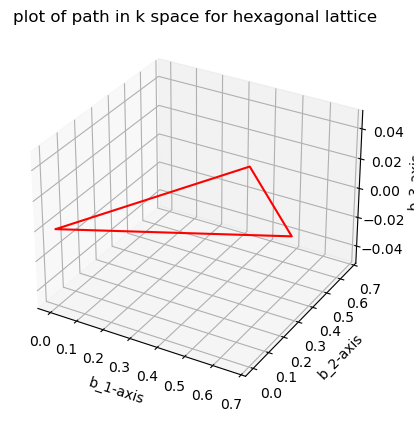

In [16]:
test_k_transpose = np.transpose(np.array(test_k_list))
b1 = test_k_transpose[0]
b2 = test_k_transpose[1]
b3 = test_k_transpose[2]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D (b1, b2, b3, 'red')
ax.set_title('plot of path in k space for hexagonal lattice')
ax.set_xlabel('b_1-axis')
ax.set_ylabel('b_2-axis')
ax.set_zlabel('b_3-axis')
plt.savefig('plot of path in k space for hexagonal lattice.png')
plt.show()


# function for finding the eigenvalues using the previous functions

In [5]:
def find_eigen(k_points,n_xvalues,lattice, orbitals,onsite,hopping):
    k_list, t_list, marker_points, n_values= k_path(k_points,n_xvalues)
    
    dimensions = len(orbitals)
    E_list = []
    for i in range(dimensions):
        E_list.append([])
    
    for k in k_list:
        Hammy = Hamiltonian(k,lattice, orbitals, onsite, hopping)
        Eigens = LA.eigvalsh(Hammy)
        for i in range(dimensions):
            E_list[i].append(Eigens[i])
        
    return E_list, t_list, marker_points

# Function using the above functions to fully plot out the badn diagram given the previous information, and save it to a figure.

In [6]:
def plot_bands(k_points,n_xvalues,lattice, orbitals,onsite,hopping,title):
    E_list, t_list, marker_points = find_eigen(k_points,n_xvalues,lattice, orbitals,onsite,hopping)
    dimensions = len(orbitals)
    title = str(title)
    
    for i in range(dimensions):
        plt.plot(t_list,E_list[i])
        
    for i in range(len(marker_points)):
        plt.axvline(marker_points[i])
        name = "k="+"["+str(round(k_points[i][0], 2))+","+str(round(k_points[i][1], 2))+","+str(round(k_points[i][2], 2))+"]"
        plt.text(marker_points[i],0,name,rotation=90)
    
    plt.xlabel("step number along path")
    plt.ylabel("Eigenvalue")
    plt.title(title)
    plt.show
    picname = title + ".png"
    plt.savefig(picname)
    

Function for drawing two dimensional primitive cells.

In [62]:
def primitive_cell_plot_2d(lattice,orbitals,title, colors):
    real_orbitals = []
    
    for i in range(len(orbitals)):
        real_orbital = np.array(lattice[0])*orbitals[i][0] + np.array(lattice[1])*orbitals[i][1] + np.array(lattice[2])*orbitals[i][2]
        real_orbitals.append(real_orbital)
    
    for i in range(len(orbitals)):
        plt.plot(real_orbitals[i][0],real_orbitals[i][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]+lattice[0][0],real_orbitals[i][1]+lattice[0][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]-lattice[0][0],real_orbitals[i][1]-lattice[0][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]+lattice[1][0],real_orbitals[i][1]+lattice[1][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]-lattice[1][0],real_orbitals[i][1]-lattice[1][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]+lattice[1][0]+lattice[0][0],real_orbitals[i][1]+lattice[1][1]+lattice[0][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]-lattice[1][0]-lattice[0][0],real_orbitals[i][1]-lattice[1][1]-lattice[0][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]+lattice[1][0]-lattice[0][0],real_orbitals[i][1]+lattice[1][1]-lattice[0][1],'ok', color=colors[i])
        plt.plot(real_orbitals[i][0]-lattice[1][0]+lattice[0][0],real_orbitals[i][1]-lattice[1][1]+lattice[0][1],'ok', color=colors[i])

        
    plt.quiver(0,0,lattice[0][0],lattice[0][1], color='r', angles='xy', scale_units='xy', scale=1)
    plt.quiver(0,0,lattice[1][0],lattice[1][1], color='b', angles='xy', scale_units='xy', scale=1)
    
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show
    picname = title + ".png"
    plt.savefig(picname)

# examples of use
Haldane model

In [19]:
#testing haldane model
path=[[0.,0.,0],[2./3.,1./3.,0],[.5,.5,0],[1./3.,2./3.,0], [0.,0.,0]]

# define lattice vectors
test_lattice=[np.array([1.0,0.0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0])]
# define coordinates of orbitals
test_orbitals=[np.array([1./3.,1./3.,0]),np.array([2./3.,2./3.,0])]


# set model parameters
delta=0.2
t=-1.0
t2 =0.15*np.exp((1.j)*np.pi/2.)
t2c=t2.conjugate()

# set on-site energies
test_onsite = [-delta,delta]
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
test_hopping = [
[t, 0, 1, [ 0, 0,0]],
[t, 1, 0, [ 1, 0,0]],
[t, 1, 0, [ 0, 1,0]],
[t2 , 0, 0, [ 1, 0,0]],
[t2 , 1, 1, [ 1,-1,0]],
[t2 , 1, 1, [ 0, 1,0]],
[t2c, 1, 1, [ 1, 0,0]],
[t2c, 0, 0, [ 1,-1,0]],
[t2c, 0, 0, [ 0, 1,0]]]

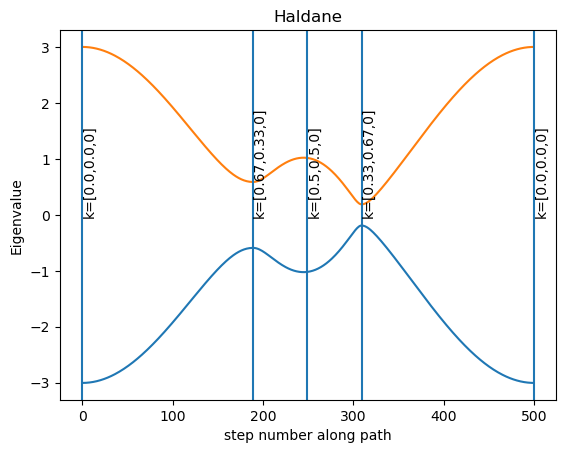

In [20]:
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"Haldane")

C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0],real_orbitals[i][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]+lattice[0][0],real_orbitals[i][1]+lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]-lattice[0][0],real_orbitals[i][1]-lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\24

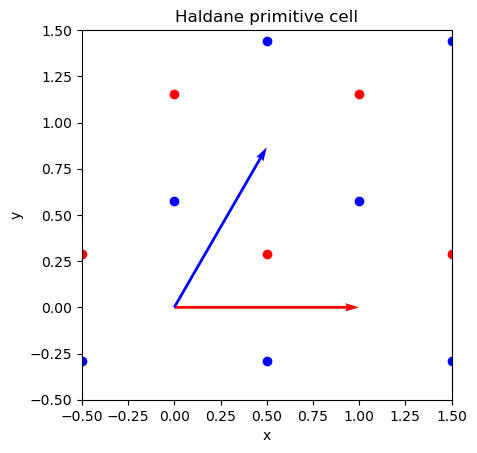

In [65]:
#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0]),np.array([0,0,0])]
test_orbitals = [np.array([1/3,1/3,0]),np.array([2/3,2/3,0])]

primitive_cell_plot_2d(test_lattice,test_orbitals,"Haldane primitive cell",["r","b"])

Graphene

In [21]:
#graphene
path = [[0,0,0], [2/3,1/3,0], [0.5,0.5,0], [0,0,0]]
#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0]),np.array([0,0,0])]
test_orbitals = [np.array([1/3,1/3,0]),np.array([2/3,2/3,0])]



# set model parameters
delta=0.0
t=-1.0

# set on-site energies
test_onsite=[-delta,delta]

# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])
test_hopping = [
[t, 0, 1, [ 0, 0,0]],
[t, 1, 0, [ 1, 0,0]],
[t, 1, 0, [ 0, 1,0]]]

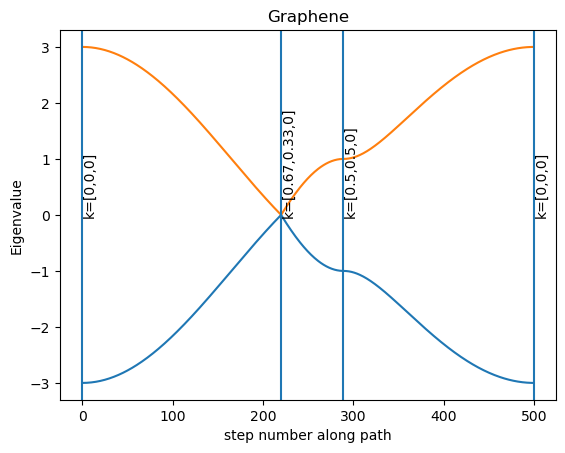

In [22]:
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"Graphene")

C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0],real_orbitals[i][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]+lattice[0][0],real_orbitals[i][1]+lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]-lattice[0][0],real_orbitals[i][1]-lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\24

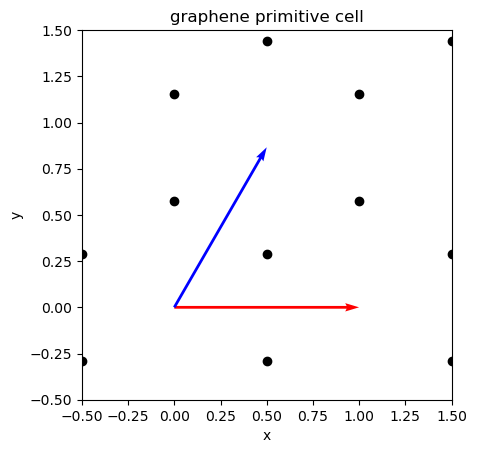

In [63]:
#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0]),np.array([0,0,0])]
test_orbitals = [np.array([1/3,1/3,0]),np.array([2/3,2/3,0])]

primitive_cell_plot_2d(test_lattice,test_orbitals,"graphene primitive cell",["k","k"])

checkerboard model

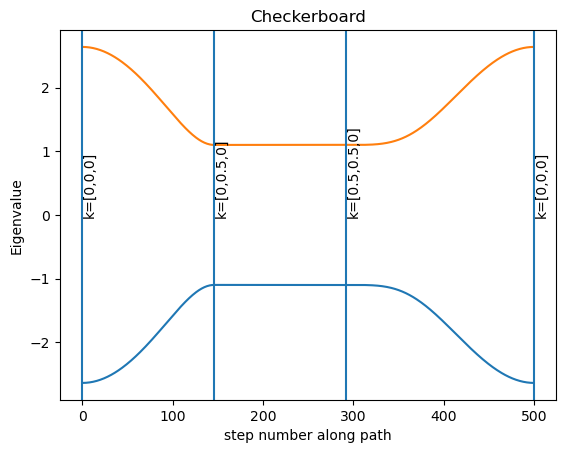

In [23]:
#checkerboard
test_lattice = [np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0]),np.array([0.5,0.5,0])]
test_onsite = [-1.1,1.1]
test_hopping = [[0.6,0,1,[0,0,0]],[0.6,0,1,[1,0,0]],[0.6,0,1,[0,1,0]],[0.6,0,1,[1,1,0]]]

path = [[0,0,0],[0,0.5,0],[0.5,0.5,0],[0,0,0]]
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"Checkerboard")

C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0],real_orbitals[i][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]+lattice[0][0],real_orbitals[i][1]+lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]-lattice[0][0],real_orbitals[i][1]-lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\24

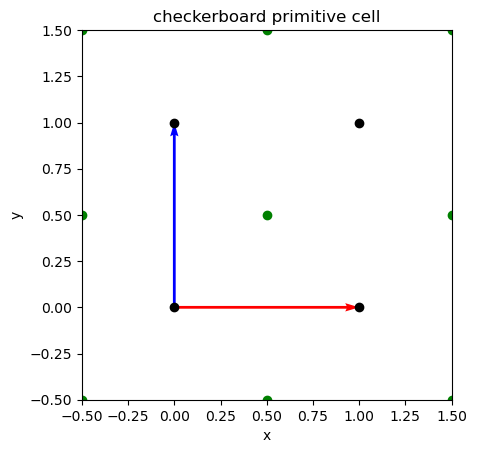

In [64]:
#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0]),np.array([0.5,0.5,0])]

primitive_cell_plot_2d(test_lattice,test_orbitals,"checkerboard primitive cell",["k","g"])

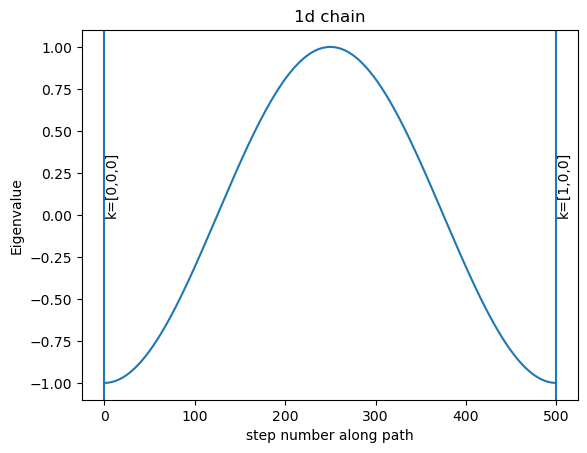

In [7]:
#1 d atom chain
test_lattice = np.array([1,0,0])
test_orbitals = np.array([0,0,0])
test_hopping = -1
test_onsite = 0

#checkerboard
test_lattice = [np.array([1,0,0]),np.array([0,0,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0])]
test_onsite = [0]
test_hopping = [[-1,0,0,[1,0,0]]]

path = [[0,0,0],[1,0,0]]
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"1d chain")

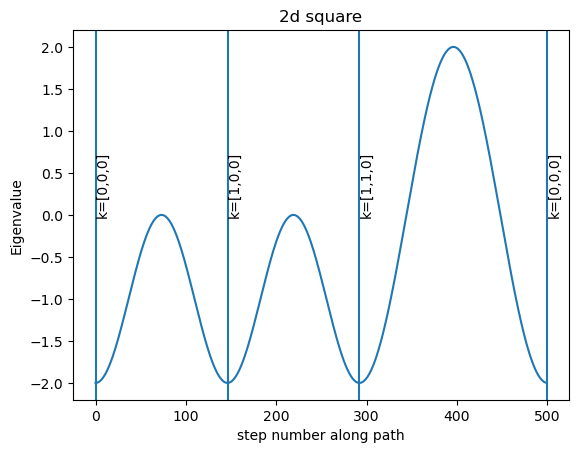

In [9]:
#2d square
test_lattice = [np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0])]
test_onsite = [0]
test_hopping = [[-1,0,0,[1,0,0]],[-1,0,0,[0,1,0]]]

path = [[0,0,0],[1,0,0],[1,1,0],[0,0,0]]
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"2d square")

C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0],real_orbitals[i][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]+lattice[0][0],real_orbitals[i][1]+lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\2459911905.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(real_orbitals[i][0]-lattice[0][0],real_orbitals[i][1]-lattice[0][1],'ok', color=colors[i])
C:\Users\Tyjal\AppData\Local\Temp\ipykernel_5260\24

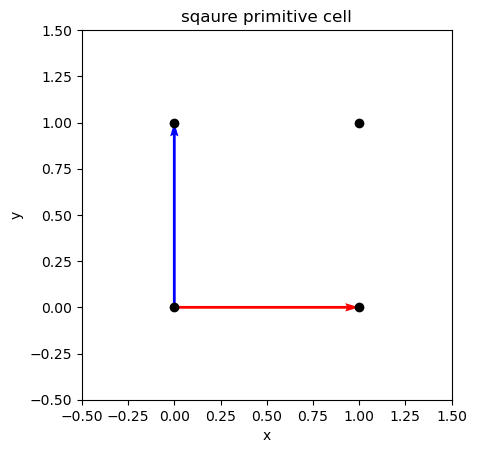

In [66]:
#lattice and positions
test_lattice = [np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0])]

primitive_cell_plot_2d(test_lattice,test_orbitals,"sqaure primitive cell",["k"])

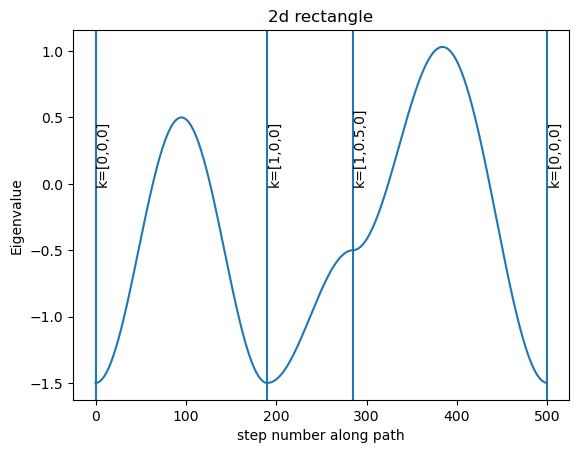

In [14]:
#2d square
test_lattice = [np.array([1,0,0]),np.array([0,2,0]),np.array([0,0,0])]
test_orbitals = [np.array([0,0,0])]
test_onsite = [0]
test_hopping = [[-1,0,0,[1,0,0]],[-0.5,0,0,[0,1,0]]]

path = [[0,0,0],[1,0,0],[1,0.5,0],[0,0,0]]
plot_bands(path,500,test_lattice, test_orbitals,test_onsite,test_hopping,"2d rectangle")

# this is code for converting betwean internal reciprocal lattice and cartesian coordinates. 
it's somewhat of a work in progress, and not complete. But may be worked on more in the future.
currently this function takes a series of lattice vectors and produces the corresponding reciprocal lattice internal coordinate vectors.
These could be used to convert a k vector in internal coordinates into cartesian coordinates, for instance if you wanted the actual k_x k_y and k_z components of the wave vector.

In [24]:
#functions for finding internal coordinates for reciprocal space
#this code will attempt to find the vectors for 1, 2, or 3 dimensional lattices. however for 2 dimensional lattices we use the formula for 3 dimensions, but specify our own third unit vector using the cross product
def b_vecs(lattice_vecs):
    b_vecs = []
    #test dimensionality
    nonzero_lattices = []
    for i in range(len(lattice_vecs)):
        if any(lattice_vecs[i]):
            nonzero_lattices.append(np.array(lattice_vecs[i]))
    d = len(nonzero_lattices)
    
    if d == 0:
        print("error, cannot do zero dimensions")
    elif d > 3:
        print("error, cannot do more than three dimensions")
    elif d == 1:
        R = np.linalg.norm(nonzero_lattices[0])
        b_vecs.append(np.array(nonzero_lattices[0]/R**2))
        b_vecs.append(np.array([0,2*np.pi,0]))
        b_vecs.append(np.array([0,0,2*np.pi]))
    elif d >= 2:
        
        if d == 2:
            #creating a third unit vector to work with
            z = np.cross(nonzero_lattices[0],nonzero_lattices[1])
            z = z/np.linalg.norm(z)
            nonzero_lattices.append(z)
        
    
        V = np.dot(nonzero_lattices[0],np.cross(nonzero_lattices[1],nonzero_lattices[2]))
        b_vecs.append(2*np.pi*np.cross(nonzero_lattices[1],nonzero_lattices[2])/V)
        b_vecs.append(2*np.pi*np.cross(nonzero_lattices[2],nonzero_lattices[0])/V)
        b_vecs.append(2*np.pi*np.cross(nonzero_lattices[0],nonzero_lattices[1])/V)
        
        
    return np.array(b_vecs)

In [25]:
#graphene
test_lattice = [np.array([1,0,0]),np.array([0.5,np.sqrt(3.0)/2.0,0]),np.array([0,0,0])]
b_vecs(test_lattice)

array([[ 6.28318531, -3.62759873,  0.        ],
       [ 0.        ,  7.25519746,  0.        ],
       [ 0.        ,  0.        ,  6.28318531]])